In [1]:
import sys

sys.path.append("..")
from omegaconf import OmegaConf
from sgm.util import instantiate_from_config

config = OmegaConf.load(
    "/vol/paramonos2/projects/antoni/code/Personal/generative-models/configs/example_training/svd_interpolation.yaml"
)
print(config)
config["model"]["params"]["ckpt_path"] = "../checkpoints/svd.safetensors"
video_model = instantiate_from_config(config.model)

/vol/paramonos2/projects/antoni/miniconda3/envs/svd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'model': {'base_learning_rate': 3e-05, 'target': 'sgm.models.diffusion.DiffusionEngine', 'params': {'input_key': 'latents', 'no_log_keys': ['audio_emb', 'fps_id', 'motion_bucket_id', 'cond_aug'], 'scale_factor': 0.18215, 'disable_first_stage_autocast': True, 'ckpt_path': 'checkpoints/svd.safetensors', 'remove_keys_from_weights': ['model.diffusion_model.input_blocks.0.0.weight'], 'compile_model': False, 'scheduler_config': {'target': 'sgm.lr_scheduler.LambdaLinearScheduler', 'params': {'warm_up_steps': [1000], 'cycle_lengths': [10000000000000], 'f_start': [1e-06], 'f_max': [1.0], 'f_min': [1.0]}}, 'use_lora': False, 'lora_config': {'search_class_str': 'Linear', 'target_replace_module': None, 'r_linear': 16, 'r_conv': 16, 'loras': None}, 'denoiser_config': {'target': 'sgm.modules.diffusionmodules.denoiser.Denoiser', 'params': {'scaling_config': {'target': 'sgm.modules.diffusionmodules.denoiser_scaling.VScalingWithEDMcNoise'}}}, 'network_wrapper': {'target': 'sgm.modules.diffusionmodules

In [ ]:
model.model.learned_mask.sum((1, 2))

In [2]:
from torchvision.io import read_video
import torch

video_path = "/data2/Datasets/HDTF/cropped_videos_original/WRA_BobbySchilling_001.mp4"
resolution = 512
device = torch.device("cuda")

video, audio, info = read_video(video_path, pts_unit="sec", output_format="TCHW")

from torchvision.transforms import Resize

resize = Resize((resolution, resolution))
video = resize(video)
print(video.shape)

  warnings.warn(



torch.Size([1000, 3, 512, 512])


In [ ]:
audio_path = "/data2/Datasets/HDTF/audio/WRA_BobbySchilling_001_whisper_emb.pt"
audio = torch.load(audio_path)
print(audio.shape)

In [5]:
model = video_model

In [ ]:
model.first_stage_model.encoder

In [32]:
model = model.to(device)
encoded = model.conditioner.embedders[3]((video[:12].to(device).float() / 255.0) * 2 - 1) * 0.18215

In [20]:
from sgm.modules.lipreader.preparation.detectors.retinaface.video_process import VideoProcess
import numpy as np

video_process = VideoProcess(
    convert_gray=False, crop_width=96 // 8, crop_height=96 // 8, reference_size=(64, 64), target_size=(64, 64)
)
landmarks = np.load("/data2/Datasets/HDTF/cropped_videos_original/RD_Radio18_000.npy")
from sgm.data.data_utils import scale_landmarks

landmarks = scale_landmarks(landmarks, (772, 772), (64, 64))

In [18]:
encoded.shape

torch.Size([6, 8, 64, 64])

In [27]:
from einops import rearrange

encoded_reshape = rearrange(encoded, "b (t c) h w -> (b t) h w c", c=4)

video_proccessed = video_process(encoded_reshape.cpu().numpy(), landmarks[:12], True, threshold=30)
video_proccessed = torch.tensor(video_proccessed)
video_proccessed = rearrange(video_proccessed, "b h w c -> b c h w")

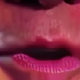

In [40]:
from PIL import Image
import numpy as np

video_model.to(device)
# decoded = video_model.decode_first_stage(encoded[:, 4:])
# encoded = video_proccessed.cuda()
decoded = video_model.decode_first_stage(encoded[:, 4:, 40:50, 30:40])
img = Image.fromarray(np.uint8((decoded[0].clip(-1, 1).cpu().numpy().transpose(1, 2, 0) + 1) * 255 / 2))
display(img)

In [ ]:
from safetensors.torch import load_file

latent_path = "/vol/bitbucket/abigata/00190_video_512_latent.safetensors"

latent = load_file(latent_path)
latent["latents"].shape

In [ ]:
decoded = video_model.decode_first_stage(latent["latents"][:1].to("cpu"))

In [ ]:
from PIL import Image
import numpy as np

img = Image.fromarray(np.uint8((decoded[0].clip(-1, 1).cpu().numpy().transpose(1, 2, 0) + 1) * 255 / 2))
display(img)

In [ ]:
import sys

sys.path.append("..")
from omegaconf import OmegaConf
from sgm.util import instantiate_from_config

config = OmegaConf.load(
    "/vol/paramonos2/projects/antoni/code/Personal/generative-models/configs/inference/sd_2_1.yaml"
)
print(config)
config["model"]["params"][
    "ckpt_path"
] = "/vol/paramonos2/projects/antoni/code/Personal/generative-models/checkpoints/v2-1_512-ema-pruned.safetensors"
model = instantiate_from_config(config.model)

In [ ]:
from torchvision.io import read_video
import torch

video_path = "/data2/Datasets/HDTF/cropped_videos_original/WRA_BobbySchilling_001.mp4"
resolution = 512
device = torch.device("cuda:4")

video, audio, info = read_video(video_path, pts_unit="sec", output_format="TCHW")

from torchvision.transforms import Resize

resize = Resize((resolution, resolution))
video = resize(video)
print(video.shape)

In [ ]:
model.to(device)
encoded = model.encode_first_stage((video[:2].to(device).float() / 255.0) * 2 - 1)

In [ ]:
# decoded = model.decode_first_stage(encoded)
decoded = model.decode_first_stage(latent["latents"][:1].to(device))

In [ ]:
from PIL import Image
import numpy as np

img = Image.fromarray(np.uint8((decoded[0].clip(-1, 1).cpu().numpy().transpose(1, 2, 0) + 1) * 255 / 2))
display(img)

In [ ]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

# load model and tokenizer
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h", cache_dir="/vol/bitbucket/abigata/.cache")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h", cache_dir="/vol/bitbucket/abigata/.cache")

In [ ]:
import torchaudio

audio_path = "/data2/Datasets/HDTF/audio/WRA_JeffFlake_001.wav"
audio, sr = torchaudio.load(audio_path)

In [ ]:
audio.shape

In [ ]:
from einops import rearrange

audio_reshaped = rearrange(audio.mean(0)[:640000], "(f s) -> f s", s=320)
audio_reshaped.shape

In [ ]:
processed = processor(audio=audio_reshaped, sampling_rate=sr, return_tensors="pt", padding="longest").input_values

In [ ]:
processed.shape

In [ ]:
import torch

normed_slice = (audio - audio.mean()) / torch.sqrt(audio.var() + 1e-7)

In [ ]:
normed_slice.shape

In [ ]:
with torch.no_grad():
    outs = model(normed_slice[:, : 16000 * 3], output_hidden_states=True)
    # hidden_states = model.wav2vec2(normed_slice)

In [ ]:
outs.logits.shape

In [ ]:
from einops import rearrange

rearanged = rearrange(hidden_states[0], "() (f d) c -> f d c", d=2)

In [ ]:
rearanged[1]

In [ ]:
outs.hidden_states[-1][:, 2:4]

In [ ]:
from torchvision.io import read_video

video_path = "/data2/Datasets/HDTF/cropped_videos_original/WRA_JeffFlake_001.mp4"
resolution = 512
device = torch.device("cuda:4")

video, audio, info = read_video(video_path, pts_unit="sec", output_format="TCHW")
video.shape

In [ ]:
outs.logits.shape, 7500 * 2

In [ ]:
predicted_ids = torch.argmax(outs.logits, dim=-1).squeeze()

# transcribe
transcription = processor.decode(predicted_ids)
transcription

In [ ]:
"NTRIES HAVE NEVER HAD FOR A SINGLE DAY IN THEIR LIVES BUT THE STORY OF THE PAST THREE AND A HALF YEARS IS A STORY OF THE POWER THAT WE VEST IN THE PRESIDENCY"

In [ ]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

# load model and tokenizer
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h", cache_dir="/vol/bitbucket/abigata/.cache")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h", cache_dir="/vol/bitbucket/abigata/.cache")

In [ ]:
model

In [ ]:
import torch
from einops import rearrange

audio_emb = torch.load("/data2/Datasets/VoxCeleb2/video/dev/mp4/id07085/NcpRWNyzlAA/00031_wav2vec2_emb.pt")
audio_emb = rearrange(audio_emb, "f d c -> (f d) c")

In [ ]:
logits = model.lm_head(audio_emb).unsqueeze(0)
predicted_ids = torch.argmax(logits, dim=-1).squeeze()

# transcribe
transcription = processor.decode(predicted_ids)
transcription

In [ ]:
# Plot video
import moviepy.editor as mp

mp.VideoFileClip("/vol/paramonos/datasets/VoxCeleb2/video/dev/mp4/id07085/NcpRWNyzlAA/00031.mp4").ipython_display()